In [1]:
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import luit as lt    #Custom library for SUMMA (https://github.com/msaharia/luit) 
from jupyterthemes import jtplot

jtplot.style(theme='grade3')

# User-supplied files

In [30]:
obsfile = '/glade/p/work/manab/fcast/data/dly/obsflow.dly.HHDW1.csv'
forcingfile = '/glade2/work/manab/newforcing/spinupforcing_20140101_20161231_3H.nc'

summafile1 = '/glade2/work/manab/output/uncalibrated_route/summaout.nc'  #Uncalibrated
routefile1 = '/glade2/work/manab/output/uncalibrated_route/routeout.nc'  #Uncalibrated

summafile2 = '/glade2/work/manab/output/calibrated_route/summaout.nc'  #Calibrated
routefile2 = '/glade2/work/manab/output/calibrated_route/routeout.nc'  #Calibrated

polyshp = '/glade/p/work/manab/fcast/data/shapefile/Region_17_merged_hru.shp'
segshp =  '/glade/p/work/manab/fcast/data/shapefile/Region17_merged_seg.shp'

hid = 17007511  #HRU ID to be plotted
sid = 17003601  #Reach ID to be plotted
pltwidth = 15
pltheight = 5
#starttime = '2014-01-10'
#endtime = '2016-12-31'   

# Reading forcings, outputs, and observations

In [43]:
forc = xr.open_dataset(forcingfile)

#Uncalib
o1 = xr.open_dataset(summafile1).set_index(hru = 'hruId')
r1 = xr.open_dataset(routefile1)

#Calib
o2 = xr.open_dataset(summafile2).set_index(hru = 'hruId')
r2 = xr.open_dataset(routefile2)

In [44]:
# Observed streamflow
o = pd.read_csv(obsfile)
o.rename(columns = {'Year':'time', 'cfs': 'flow'}, inplace=True)

o['flow2'] = o['flow']*0.0283 #Convert to CMS
o['time'] = pd.to_datetime(o['time'])  #convert to datetime format
#o.loc[o['flow'] < 0 , 'flow'] = np.nan
#o.fillna(method='ffill', limit=10)

o = o.set_index(['time'])
obs = o.to_xarray()

# Howard Hanson Reservoir

The 24 upstream HRU IDs are: [17007385 17007386 17007424 17007430 17007447 17007453 17007454 17007471
 17007483 17007498 17007511 17007517 17007536 17007541 17007550 17007554
 17007569 17007639 17009584 17009585 17009586 17009587 17009598 17009599]

The 8 REACH IDs are: [17003601 17003602 17003603 17003604 17003605 17003616 17003617 17003618]



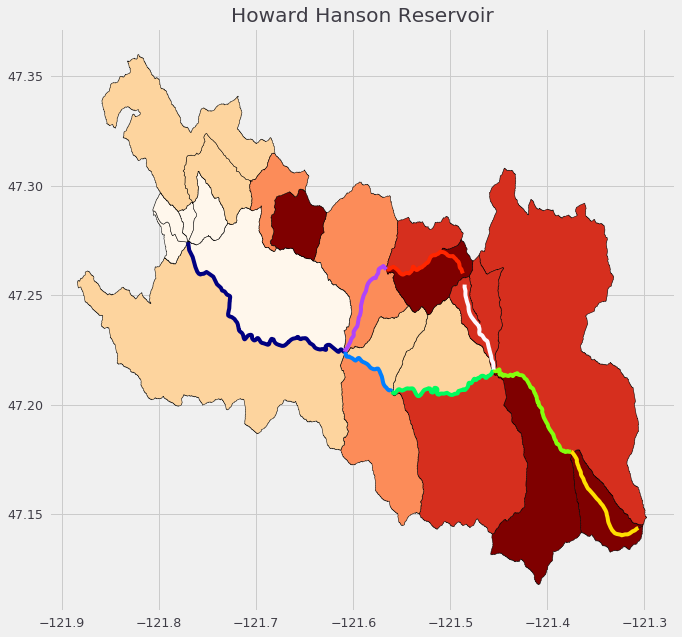

In [45]:
#Polygon shapefile
hrus = o1['hru'].values
print('The ' + str(len(hrus)) + ' upstream HRU IDs are: ' + str(hrus) + '\n')
polydat = lt.subShp(polyshp, 'hru_id2', hrus)

#Reach shapefile
reaches = r1['reachID'].values
print('The ' + str(len(reaches)) + ' REACH IDs are: ' + str(reaches) + '\n')
segdat = lt.subShp(segshp, 'seg_id2', reaches)

#Plotting and overlaying
f, ax = plt.subplots(1, figsize=(10, 10))
plt.style.use('fivethirtyeight')
ax.set_title('Howard Hanson Reservoir')
polydat.plot(ax = ax, column = 'Elev_Avg', cmap='OrRd', scheme='quantiles', edgecolor='black')
segdat.plot(ax = ax, cmap = 'gist_ncar')
ax.grid(True)

In [46]:
def unitConvert(ncout):
    '''Unit conversion for diagnostics
    ncout: Ingested SUMMA output
    '''
    ncout['pptrate'] = ncout['pptrate']*3600      #kg m-2 s-1 -> mm/hr
    ncout['averageInstantRunoff'] = ncout['averageInstantRunoff']*3600000  #m/s to mm/h
    ncout['scalarAquiferBaseflow'] = ncout['scalarAquiferBaseflow']*3600000  #m/s to mm/h
    ncout['scalarRainPlusMelt'] = ncout['scalarRainPlusMelt']*3600000  #m/s to mm/h
    ncout['scalarAquiferRecharge'] = ncout['scalarAquiferRecharge']*3600000  #m/s to mm/h
    ncout['scalarAquiferStorage'] = ncout['scalarAquiferStorage']*1000  #m to mm
    ncout['scalarAquiferTranspire'] = ncout['scalarAquiferTranspire']*3600000  #m/s to mm/h
    ncout['scalarSurfaceRunoff'] = ncout['scalarSurfaceRunoff']*3600000  #m/s to mm/h
    return(ncout)

out1 = unitConvert(o1)  #Uncalibrated
out2 = unitConvert(o2)  #Calibrated

# PLOTS

In [86]:
starttime = '2014-03-01'
endtime = '2014-12-31'

def plotncvar(ncout, ncvar, hid, xlabel, ylabel):
    '''Plots netCDF variables temporally. Start and End time
    set globally
    
    ncout: SUMMA output file with properly converted units
    ncvar: Variable to be plotted
    hid: HRU ID to be plotted
    xlabel: Label of the x-axis
    ylable: Label of the y-axis
    '''
    plt.figure(figsize=(12, 3))
    ncout.sel(hru=hid)[ncvar].loc[starttime:endtime].plot()
    plt.ylabel(xlabel, fontsize = 16)
    plt.xlabel("")
    plt.title("")
    plt.show()
    
def plotFracLiq(ncout, hid):
    '''Plots Volumetric Fraction in each layer
    
    ncout: SUMMA output file with properly converted units
    '''
    iden_water = 1000
    plt.figure(figsize=(12, 3))
    (ncout.sel(hru = hid)['mLayerVolFracLiq'][:, 0]*iden_water*0.5).plot(label='Top Soil Layer')
    (ncout.sel(hru = hid)['mLayerVolFracLiq'][:, 1]*iden_water*1.5).plot(label='Middle Soil Layer')
    (ncout.sel(hru = hid)['mLayerVolFracLiq'][:, 2]*iden_water*2.0).plot(label='Bottom Soil Layer')
    plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.3), ncol=2, fancybox=True, shadow=True)
    plt.ylabel('Liquid Water (mm)', fontsize=16) 
    plt.show()

def metaPlotter(ncout):
    '''Makes all the plots in one place
    
    ncout: SUMMA output file with properly converted units
    '''
    plotncvar(ncout, 'pptrate', 17007511, 'Precip Rate (mm/h)', 'TIME')
    plotncvar(ncout, 'airtemp', 17007511, 'Air Temperature (K)', 'TIME')
    plotncvar(out2, 'scalarSWE', 17007511, 'SWE (mm)', 'TIME')
    plotncvar(ncout, 'scalarTotalSoilWat', 17007511, 'Soil Moisture (mm)', 'TIME')
    plotncvar(ncout, 'scalarAquiferStorage', 17007511, 'Scalar Aquifer Storage (mm)', 'TIME')
    plotncvar(ncout, 'scalarAquiferBaseflow', 17007511, 'Scalar Aquifer Baseflow (mm)', 'TIME')
    plotncvar(ncout, 'averageInstantRunoff', 17007511, 'Runoff (mm/h)', 'TIME')
    plotFracLiq(out2, 17007511) #mLayerVolFracLiq

# HRU ID 17007511

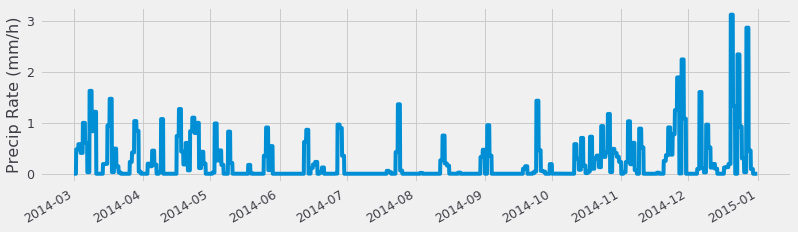

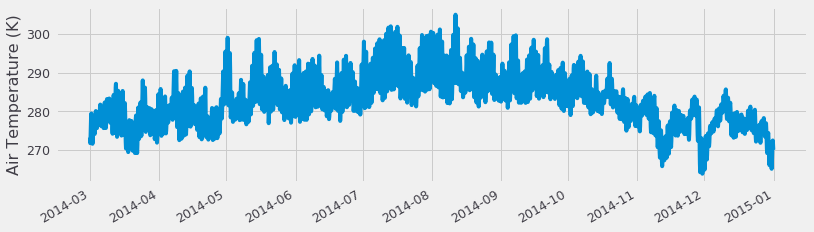

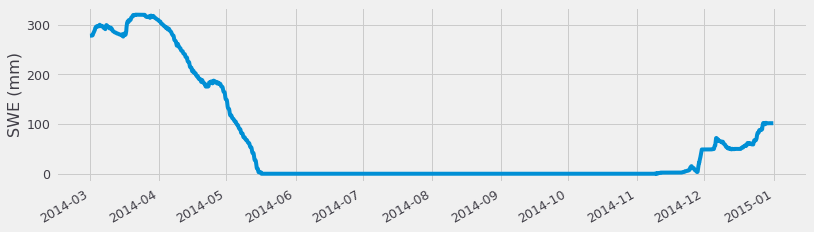

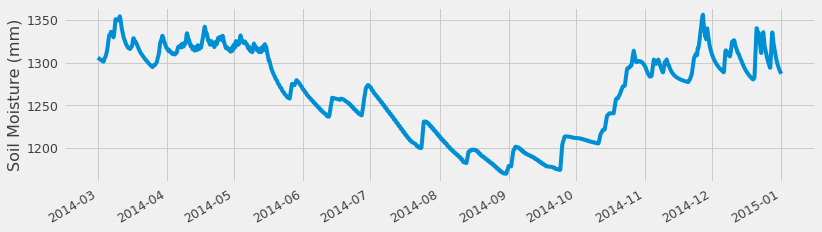

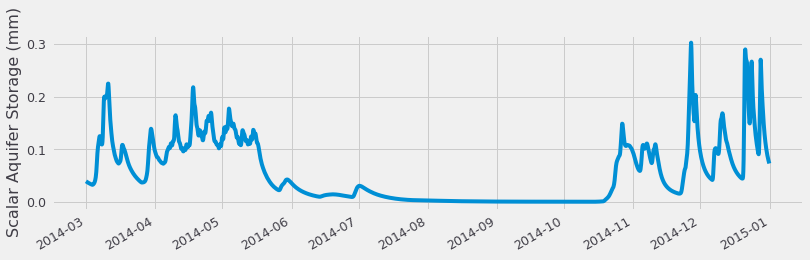

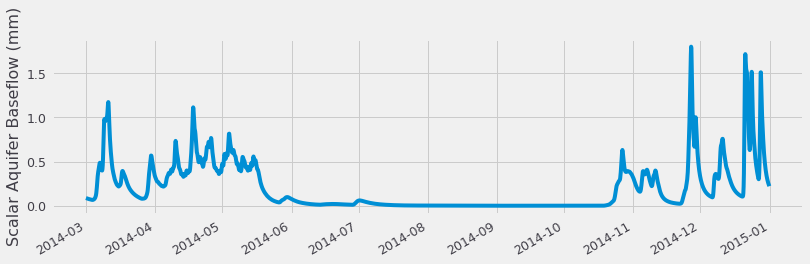

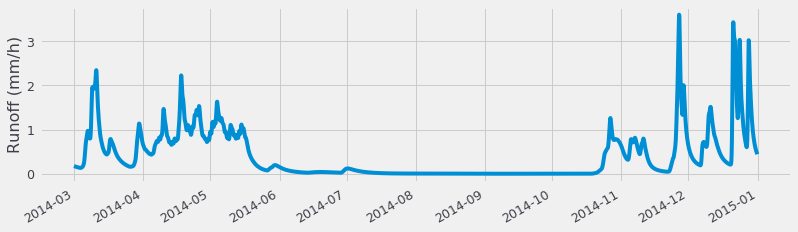

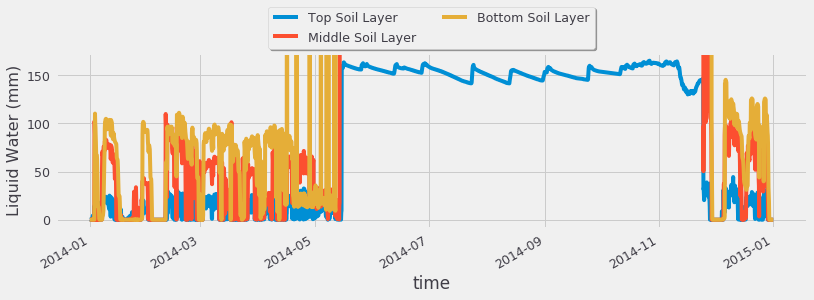

In [88]:
metaPlotter(out1)

In [ ]:
# Water Balance



In [89]:
starttime = '2014-02-01'
endtime = '2014-12-31'

#Streamflow
uncalib = xr.open_dataset('/glade2/work/manab/output/uncalibrated_route/routeout.nc').set_index(sSeg = 'reachID')
calib = xr.open_dataset('/glade2/work/manab/output/calibrated_route/routeout.nc').set_index(sSeg = 'reachID')

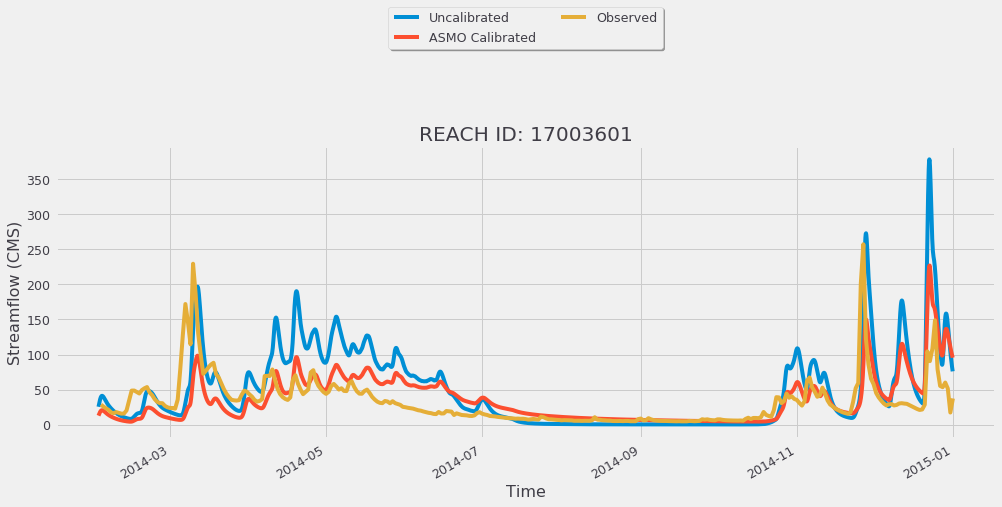

In [90]:
plt.style.use('fivethirtyeight')
plt.figure(figsize=(pltwidth,pltheight))
uncalib.sel(sSeg = sid)['IRFroutedRunoff'].loc[starttime:endtime].plot(label='Uncalibrated')
calib.sel(sSeg = sid)['IRFroutedRunoff'].loc[starttime:endtime].plot(label='ASMO Calibrated')
obs['flow2'].loc[starttime:endtime].plot(label='Observed')
plt.ylabel('Streamflow (CMS)', fontsize=16)
plt.xlabel('Time', fontsize=16)
plt.title('REACH ID: %i' %sid)
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.5), ncol=2, fancybox=True, shadow=True)
plt.show()